In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import arviz

Tạo dữ liệu mô phỏng

In [63]:
np.random.seed(42)
mu = 10
sigma2 = 1
group_mu = np.random.normal(loc=mu, scale=sigma2, size=20)
group_mu[1] = group_mu[0]
data_group = { i : [] for i in range(len(group_mu)) }
for i in range(200):
    for j in range(len(data_group)):
        data_group[j].append(np.random.normal(loc= group_mu[j], scale=1))

In [64]:
print(group_mu)

[10.49671415 10.49671415 10.64768854 11.52302986  9.76584663  9.76586304
 11.57921282 10.76743473  9.53052561 10.54256004  9.53658231  9.53427025
 10.24196227  8.08671976  8.27508217  9.43771247  8.98716888 10.31424733
  9.09197592  8.5876963 ]


In [65]:
#Định nghĩa một số hàm cần dùng

def Gibbs_Process(iter,mu0, gamma0, shape_tau, rate_tau, shape_sig, rate_sig, size, numof_group, data_group, para, MSE):
    para_temp = para.mean().values
    columns_name = para.columns
    para = pd.DataFrame(np.array([para_temp]), columns= columns_name)
    for i in range(iter):
        k = 0
        for j in columns_name:
            if k == 0:
                para_temp[0] = np.random.normal(((para_temp.sum() - para_temp[0] - para_temp[1] - para_temp[2]) / para_temp[1] + mu0/gamma0)/(numof_group/para_temp[1] + 1 / gamma0), (1/(numof_group/para_temp[1] + 1/gamma0**2))**0.5)
                k = k +1
            elif k == 1:
                MSE_theta = para_temp - para_temp[0]
                MSE_theta = np.dot(MSE_theta, MSE_theta)  - (para_temp[1]-para_temp[0])**2 - (para_temp[2]-para_temp[0])**2
                para_temp[1] = 1 / np.random.gamma((2* shape_tau + numof_group)/2,1/((2*rate_tau + MSE_theta)/2))
                k = k +1
            elif k == 2:
                para_temp[2] = 1 / np.random.gamma((2*shape_sig + size * numof_group/2),1/(rate_sig + MSE.sum()/2))
                k = k + 1
            else:
                para_temp[k] = np.random.normal((sum(data_group[k-3][0:size])/para_temp[2] + para_temp[0] / para_temp[1])/(size/ para_temp[2] + 1 /para_temp[1]),(1 / (size/para_temp[2] + 1 / para_temp[1]))**0.5)
                MSE1 = np.array(data_group[k-3][0: size] - para_temp[k])
                MSE1 = np.dot(MSE1, MSE1)
                MSE[k-3] = MSE1
                k = k + 1
        para = pd.concat([para, pd.DataFrame(np.array([para_temp]), columns= columns_name)], ignore_index= True)  
    return para

def Gibbs_Sampling(iter,mu0, gamma0, shape_tau, rate_tau, shape_sig, rate_sig, size, numof_group, data_group):
    columns_name = ["mu", "tau**2", "sig**2"] + [f"mu{i}" for i in range(numof_group)]
    # Tạo DataFrame với các cột mu, tau, sig và các cột theta được tạo tự động
    para = pd.DataFrame(np.ones((1,  len(columns_name)))*20 ,columns= columns_name)
    MSE = np.zeros((numof_group,), dtype=float)
    for i in range(numof_group):
        tmp_array = np.array(data_group[i][0: size])
        tmp_array = tmp_array - tmp_array.mean()
        MSE[i] = np.dot(tmp_array, tmp_array)
    para = Gibbs_Process(100,mu0, gamma0, shape_tau, rate_tau, shape_sig, rate_sig, size, numof_group, data_group, para, MSE) # Burn - in
    para = Gibbs_Process(iter,mu0, gamma0, shape_tau, rate_tau, shape_sig, rate_sig, size, numof_group, data_group, para, MSE)
    return para    

def trace_plot(data, str):
    trace_values = np.zeros((len(data),), dtype=float)
    tmp = 0
    for i in range(len(data)):
        tmp += data[i]
        trace_values[i] = tmp/(i+1)
    plt.figure(figsize=(8, 4))
    plt.plot(trace_values, marker='', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{str}')
    plt.grid(True)
    plt.show()

def trace_plot_var(data, str = " "):
    trace_values = np.zeros((len(data),), dtype=float)
    for i in range(len(data)):
        tmp = np.array(data[:i] - np.array(data[:i]).mean())
        trace_values[i] = np.dot(tmp, tmp) / (i if i > 0 else 1 )
        if( i > 1):
            if(trace_values[i] - trace_values[i-1]) > 25:
                print(i,data[i], trace_values[i] - trace_values[i-1])
    plt.figure(figsize=(8, 4))
    plt.plot(trace_values, marker='', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{str}')
    plt.grid(True)
    plt.show()    

def autocorr(x, y, lag):
    #Hai chuỗi cần chung độ dài
    mean_x = sum(x)/len(x)
    mean_y = sum(y)/len(y)
    n = len(x)
    return np.dot(np.array(x[:n - lag] - mean_x), np.array(y[lag:] - mean_y)) / np.dot(np.array(x - mean_x), np.array(y-mean_y))
def ACF_plot(x,y, lag_max, str1 = " ", str2= " "):
    acf_values = [autocorr(x, y,lag) for lag in range(lag_max+1)]
    plt.figure(figsize=(8, 4))
    plt.stem([i for i in range(lag_max+1)], acf_values)
    #plt.bar(lag_max, acf_values)
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title(f"Autocorrelation Function {str1} and {str2}")
    plt.grid(True)
    plt.show()
    
def ESS_sample(x, lag_max):
    acf_values = [autocorr(x, x,lag) for lag in range(lag_max+1)]
    denom = 1
    for i in range(len(acf_values)-1):
        if abs(acf_values[i+1]) < 0.01:
            break
        denom += 2* acf_values[i+1]
        if i+1 > lag_max:
            break
    return len(x) / denom
            

Thiết lập mô hình phân cấp

In [85]:
#Tiên nghiệm của mu
mu0 = 1
gamma0 = 1
#Tiên nghiệm của 1/tau**2
shape_tau = 2
rate_tau  = 2
#Tiên nghiệm của 1/sigma**2
shape_sig = 2
rate_sig = 2
#Cỡ nhóm và số nhóm
size = 70
numof_group = 3

In [86]:
np.random.seed(42)
para = Gibbs_Sampling(10000, mu0, gamma0, shape_tau, rate_tau, shape_sig, rate_sig, size, numof_group, data_group)

In [87]:
para.mean()

mu         1.796300
tau**2    48.340470
sig**2     1.102482
mu0       10.596812
mu1       10.532208
mu2       10.753042
dtype: float64

In [88]:
para.var()

mu           1.119466
tau**2    1750.403185
sig**2       0.011498
mu0          0.015176
mu1          0.015846
mu2          0.015815
dtype: float64

In [89]:
group_mu

array([10.49671415, 10.49671415, 10.64768854, 11.52302986,  9.76584663,
        9.76586304, 11.57921282, 10.76743473,  9.53052561, 10.54256004,
        9.53658231,  9.53427025, 10.24196227,  8.08671976,  8.27508217,
        9.43771247,  8.98716888, 10.31424733,  9.09197592,  8.5876963 ])

In [90]:
[sum(data_group[i][0:size])/size for i in range(numof_group)]

[10.60109945207756, 10.532679626383233, 10.754418399488205]

In [91]:
1 - sum((para['mu2']-para['mu1'])>0)/10000

0.10460000000000003

In [92]:
from scipy.stats import f_oneway
list_of_data_groups = [data_group[2][0:size], data_group[1][0:size] ]
f_statistic, p_value = f_oneway(*list_of_data_groups)

print("F-Statistic:", f_statistic)
print("P-value:", p_value)

F-Statistic: 1.4528688441241502
P-value: 0.23013096389861032


C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_24928\3170430483.py:60: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


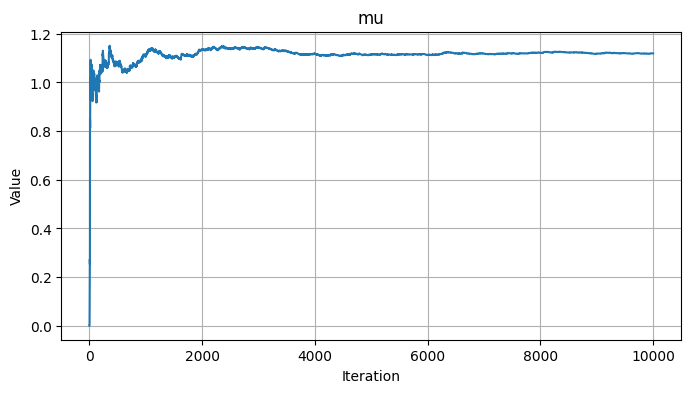

In [93]:
trace_plot_var(para['mu'], "mu")

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_24928\3170430483.py:60: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


3 24.102254544592878 98.57682843431809
4 75.98282092992997 41.73552238271954
5 40.49801335971075 199.23992342625402
10 29.17802447497759 113.67593108919505
15 22.72303900693019 63.794802560484015
28 275.26266927645423 45.79273620378643
29 89.36492207178337 1787.4780812471226
40 39.8547363753705 1679.333849447639
101 542.0739990457113 50.120697238220146
102 38.855849195541175 2353.4130754231496
109 70.8143499510671 1491.162336579444
173 34.478302343875995 307.99792113992544
235 24.50806060555797 36.813752831591046
242 45.49818442904303 98.05494433822741
286 22.922703944016952 582.663991519848
554 33.46541730298978 46.59935833223062
677 130.2415219152192 62.95332957086225
708 32.10685447077688 140.99387504448464
715 52.93809579831555 30.592051928497312
843 206.56056718922162 61.140548613802366
844 92.89419485862602 27.07597612439804
1122 51.24603488071068 45.87449095231818
1161 79.57652108345414 86.10787513459832
1206 30.305636470700318 25.03324232826708
1372 46.349553256703324 28.037548

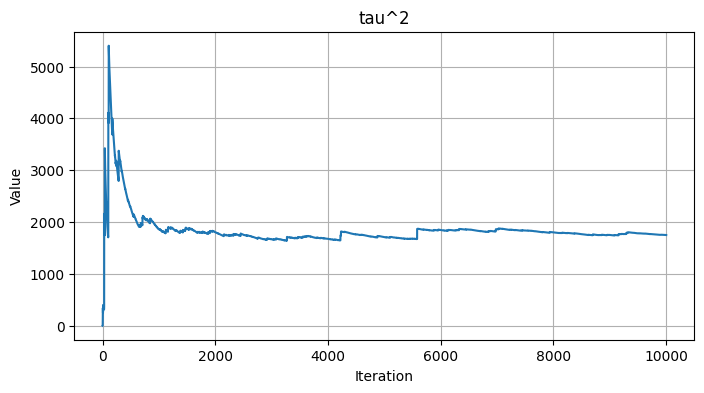

In [94]:
trace_plot_var(para['tau**2'], "tau^2")

In [95]:
para['tau**2'][5580:5584]

5580    1090.847884
5581      50.383941
5582      47.623767
5583      51.192458
Name: tau**2, dtype: float64

In [96]:
para['mu'][5580:5584]

5580    0.144492
5581    1.367187
5582   -0.207762
5583    1.507341
Name: mu, dtype: float64

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_24928\3170430483.py:60: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


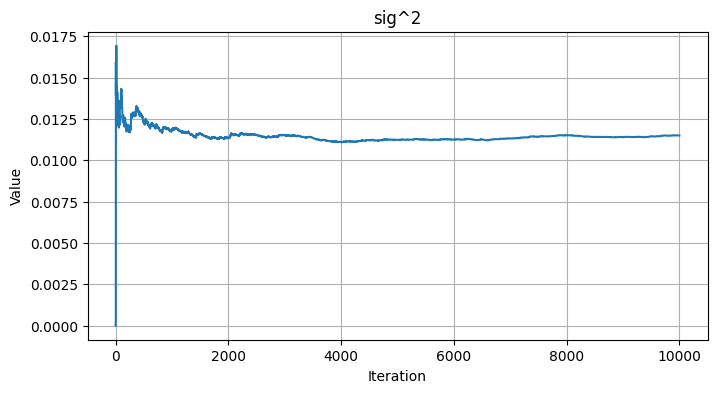

In [97]:
trace_plot_var(para['sig**2'], "sig^2")

C:\Users\KyThuat88\AppData\Local\Temp\ipykernel_24928\3170430483.py:60: RuntimeWarning: Mean of empty slice.
  tmp = np.array(data[:i] - np.array(data[:i]).mean())


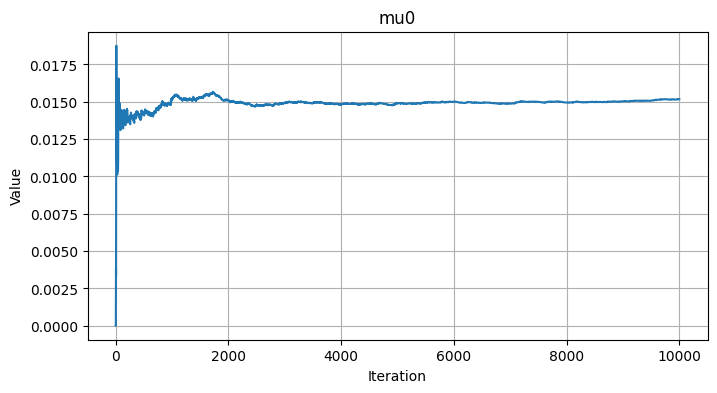

In [98]:
trace_plot_var(para['mu0'], "mu0")

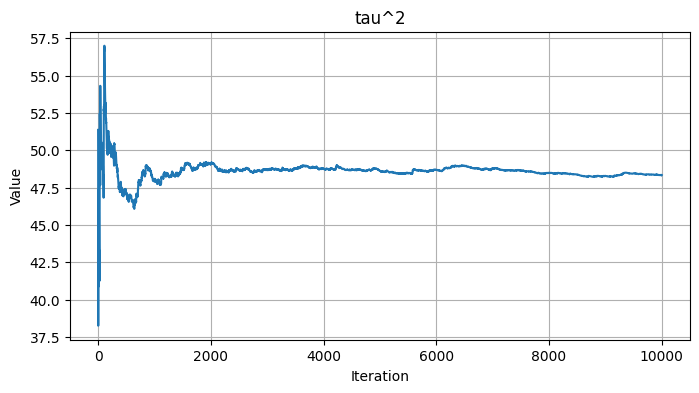

In [99]:
trace_plot(para['tau**2'], "tau^2")

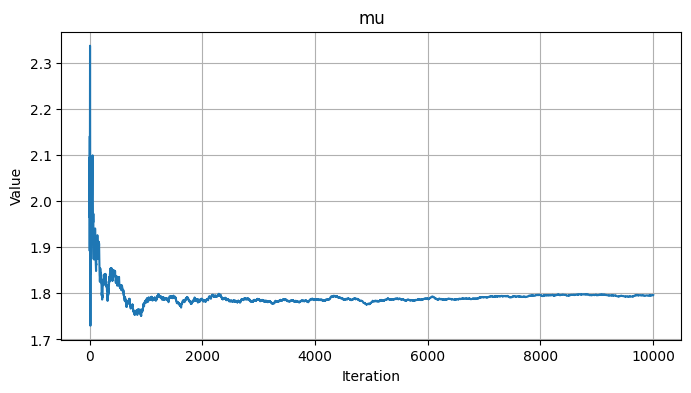

In [100]:
trace_plot(para['mu'], "mu")

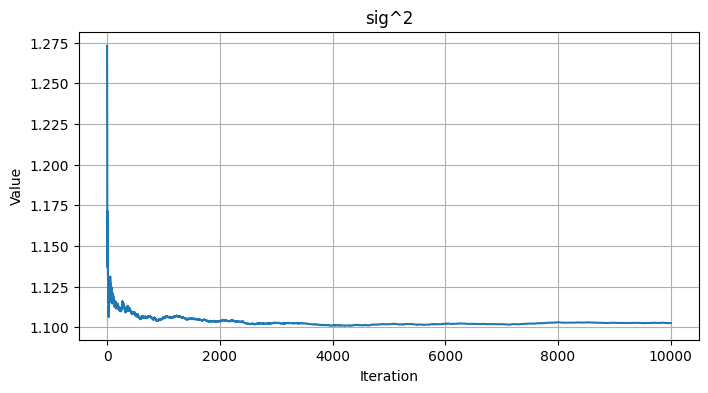

In [101]:
trace_plot(para['sig**2'], "sig^2")

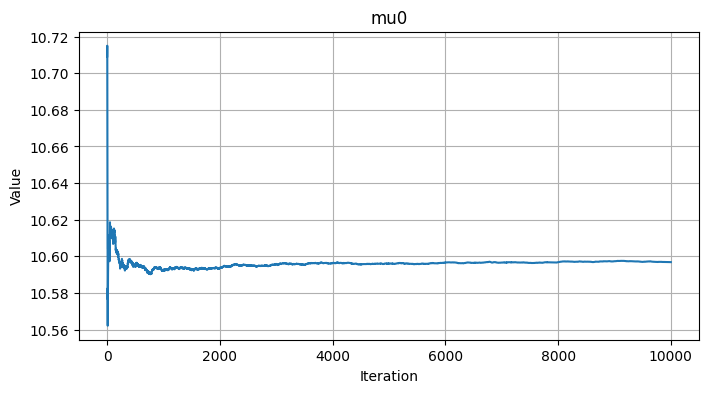

In [102]:
trace_plot(para['mu0'], "mu0")

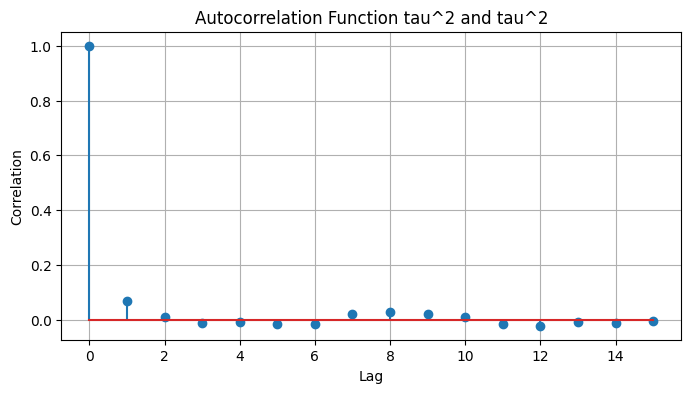

In [103]:
ACF_plot(para['tau**2'], para['tau**2'],15 ,"tau^2", "tau^2")